In [1]:
import pandas as pd
import sys
import seaborn as sns
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from tqdm import tqdm

Questions that interest me:
- is the game balanced?
- is the game balanced across all skill levels?
- does the first role (att/def) matter for the outcome?
  - for example: are you more likely to win on a defender favoured map if you start on defence?
  - how many maps are att/def favoured -> what does that imply regarding the previous result?

####  load a small subset of the data to get a sense of which information is necessary and which can be ignored for the time being

In [2]:
df = pd.read_csv("./data/datadump_s5-000.csv", nrows=10)
df.head()

,dateid,platform,gamemode,mapname,matchid,roundnumber,objectivelocation,winrole,endroundreason,roundduration,...,primarygrip,primaryunderbarrel,primarybarrel,secondaryweapon,secondaryweapontype,secondarysight,secondarygrip,secondaryunderbarrel,secondarybarrel,secondarygadget
0,20170212,PC,HOSTAGE,CLUB_HOUSE,1522380841,1,STRIP_CLUB,Defender,AttackersKilledHostage,124,...,Vertical,None,Compensator,5.7_USG,Pistols,None,None,None,None,IMPACT_GRENADE
1,20170212,PC,HOSTAGE,CLUB_HOUSE,1522380841,4,CHURCH,Defender,AttackersEliminated,217,...,Vertical,Laser,Suppressor,P12,Pistols,None,None,Laser,Suppressor,DEPLOYABLE_SHIELD
2,20170212,PC,HOSTAGE,CLUB_HOUSE,1522380841,3,CHURCH,Defender,AttackersEliminated,160,...,None,None,None,MK1_9mm,Pistols,None,None,None,None,DEPLOYABLE_SHIELD
3,20170212,PC,HOSTAGE,CLUB_HOUSE,1522380841,4,CHURCH,Defender,AttackersEliminated,217,...,None,None,MuzzleBrake,PRB92,Pistols,None,None,None,None,IMPACT_GRENADE
4,20170212,PC,HOSTAGE,CLUB_HOUSE,1522380841,6,BEDROOM,Attacker,DefendersEliminated,143,...,Vertical,Laser,Suppressor,P12,Pistols,None,None,Laser,Suppressor,DEPLOYABLE_SHIELD


#### load a single full dataset with only relevant columns (weapon information has been ignored)

In [3]:
def load_gamedata(filepath):
    return pd.read_csv(
        filepath,
        usecols={
            "dateid",
            "platform",
            "gamemode",
            "mapname",
            "matchid",
            "roundnumber",
            "objectivelocation",
            "winrole",
            "endroundreason",
            "roundduration",
            "clearancelevel",
            "skillrank",
            "role",
            "team",
            "haswon",
            "operator",
            "nbkills",
            "isdead"
        },
        dtype={
            "dateid": "int64",
            "platform": "category",
            "gamemode": "category",
            "mapname": "category",
            "matchid": "int64",
            "roundnumber": "int64",
            "objectivelocation": "category",
            "winrole": "category",
            "endroundreason": "category",
            "roundduration": "int64",
            "clearancelevel": "int64",
            "skillrank": "category",
            "role": "category",
            "team": "int64",
            "haswon": "boolean",
            "operator": "category",
            "nbkills": "int64",
            "isdead": "boolean"
        },
    )


In [4]:
df = load_gamedata(filepath="./data/datadump_s5-000.csv")
df.shape

(4000000, 18)

In [5]:
# by reducing the data to the necessary information and declaring specific datatypes the size of the dataframe can be reduces from ~5.7 GB to ~270 MB (a reduction by about 95%)
print("DF size:", round(sys.getsizeof(df) / (1024 ** 2), 2), "MB")

DF size: 267.05 MB


#### reduce the data even further by only including the most relevant data (PC platform and BOMB gamemode, both of which are the most competitive)

In [6]:
df["platform"].value_counts()

PS4     1875227
XONE    1535452
PC       589321
Name: platform, dtype: int64

In [7]:
df["gamemode"].value_counts()

SECURE_AREA    2580520
BOMB            954914
HOSTAGE         464566
Name: gamemode, dtype: int64

In [8]:
def reduce_data(data):
    return data.loc[(data["platform"] == "PC") & (data["gamemode"] == "BOMB")]

In [9]:
df = reduce_data(data=df)
df.shape

(208929, 18)

In [10]:
print("DF size in MB:", round(sys.getsizeof(df) / (1024 ** 2), 2))

DF size in MB: 15.56


#### since the size of the relevant data is small enough by now, we load all datasets

In [11]:
# TODO: BE CAREFULL ABOUT THE CATEGORIES

df_list = []
for i in range(0, 22):
    print(f"loading ./data/datadump_s5-{i:03}.csv")
    df_tmp = load_gamedata(filepath=f"./data/datadump_s5-{i:03}.csv")
    df_tmp = reduce_data(data=df_tmp)
    df_list.append(df_tmp)

loading ./data/datadump_s5-000.csv
loading ./data/datadump_s5-001.csv
loading ./data/datadump_s5-002.csv
loading ./data/datadump_s5-003.csv
loading ./data/datadump_s5-004.csv


ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
df_complete = pd.concat(df_list, ignore_index=True)
df_complete.shape

In [ ]:
print("DF size in MB:", round(sys.getsizeof(df_complete) / (1024 ** 2), 2))

In [43]:
df_complete.to_csv("./data/data_reduced.csv", index=False)

In [5]:
df["date"] = pd.to_datetime(df["dateid"], format="%Y%m%d")
arr = df["date"].unique()
arr

array(['2017-02-23T00:00:00.000000000', '2017-02-24T00:00:00.000000000',
       '2017-02-26T00:00:00.000000000', '2017-03-07T00:00:00.000000000',
       '2017-03-20T00:00:00.000000000', '2017-03-23T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [10]:
df["gamemode"].value_counts()

SECURE_AREA    2618694
BOMB            945327
HOSTAGE         435979
Name: gamemode, dtype: int64

In [11]:
print("df size:", sys.getsizeof(df) / 1024**3, "GB")

df size: 3.428254058584571 GB


In [12]:
print("unique matches:", df["matchid"].nunique())

unique matches: 74604


In [13]:
df["skillrank"] = df["skillrank"].cat.reorder_categories(["Unranked", "Copper", "Bronze", "Silver", "Gold", "Platinum", "Diamond"])
df["skillrank"].dtype

CategoricalDtype(categories=['Unranked', 'Copper', 'Bronze', 'Silver', 'Gold', 'Platinum',
                  'Diamond'],
, ordered=False)

<AxesSubplot:xlabel='skillrank', ylabel='roundduration'>

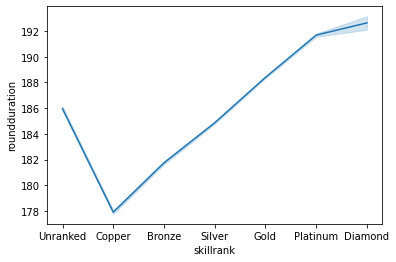

In [14]:
sns.lineplot(data=df[["skillrank", "roundduration"]], x="skillrank", y="roundduration")

In [15]:
df_rankings = df.loc[df["platform"] == "PC"]["skillrank"].value_counts(sort=False).reset_index(name="count").rename(columns={"index": "skillrank"})
df_rankings

# todo: pro platform normalisieren

,skillrank,count
0,Unranked,55616
1,Copper,35589
2,Bronze,62780
3,Silver,116144
4,Gold,226060
5,Platinum,67316
6,Diamond,3807


In [16]:
#min_max_scaler = preprocessing.MinMaxScaler()
#scaled_counts = min_max_scaler.fit_transform(df_rankings["count"].values)
#scaled_counts

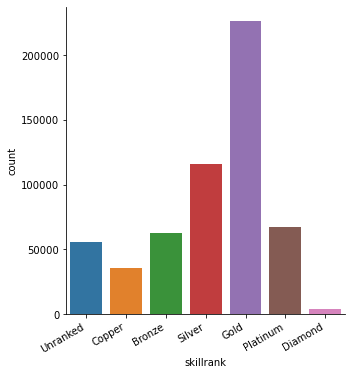

In [17]:
my_plot = sns.catplot(data=df_rankings, y="count", x="skillrank", kind="bar")
my_plot.set_xticklabels(rotation=30, ha='right')

In [18]:
df["platform_numeric"] = df["platform"].cat.codes
df["skillrank_numeric"] = df["skillrank"].cat.codes
df["mapname_numeric"] = df["mapname"].cat.codes
df["role_code"] = df["role"].cat.codes

In [19]:
corr_matrix = df[["clearancelevel", "haswon", "nbkills", "isdead", "platform_numeric", "skillrank_numeric", "mapname_numeric", "role_code", "roundduration"]].corr()
corr_matrix

,clearancelevel,haswon,nbkills,isdead,platform_numeric,skillrank_numeric,mapname_numeric,role_code,roundduration
clearancelevel,1.000000,0.026083,0.072116,-0.018518,-0.022131,0.522528,0.000389,0.000701,0.055658
haswon,0.026083,1.000000,0.249302,-0.565033,0.002256,0.033387,-0.000059,0.000890,-0.011793
nbkills,0.072116,0.249302,1.000000,-0.366081,-0.000358,0.067544,0.001681,-0.022016,0.060858
isdead,-0.018518,-0.565033,-0.366081,1.000000,-0.000776,-0.020323,0.004490,0.030668,0.120433
platform_numeric,-0.022131,0.002256,-0.000358,-0.000776,1.000000,0.000983,-0.004005,0.000305,-0.045264
skillrank_numeric,0.522528,0.033387,0.067544,-0.020323,0.000983,1.000000,-0.002665,-0.000141,0.070549
mapname_numeric,0.000389,-0.000059,0.001681,0.004490,-0.004005,-0.002665,1.000000,-0.000148,-0.027910
role_code,0.000701,0.000890,-0.022016,0.030668,0.000305,-0.000141,-0.000148,1.000000,0.009539
roundduration,0.055658,-0.011793,0.060858,0.120433,-0.045264,0.070549,-0.027910,0.009539,1.000000


<AxesSubplot:>

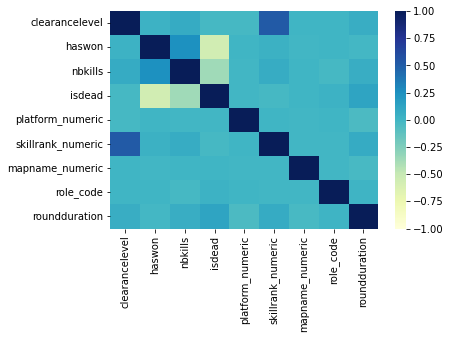

In [20]:
sns.heatmap(corr_matrix, center=0, vmin=-1, vmax=1, cmap="YlGnBu")

In [21]:
# df.loc[df["skillrank_numeric"]][["skillrank_numeric", "roundduration"]].corr()
df_tmp = df.loc[~(df["skillrank"] == "Unranked")][["skillrank_numeric", "roundduration"]]
df_tmp.corr()

,skillrank_numeric,roundduration
skillrank_numeric,1.000000,0.091481
roundduration,0.091481,1.000000


In [22]:
df_tmp.groupby("skillrank_numeric")["roundduration"].median()

skillrank_numeric
1    177.0
2    182.0
3    187.0
4    192.0
5    197.0
6    199.0
Name: roundduration, dtype: float64

<AxesSubplot:xlabel='skillrank_numeric', ylabel='roundduration'>

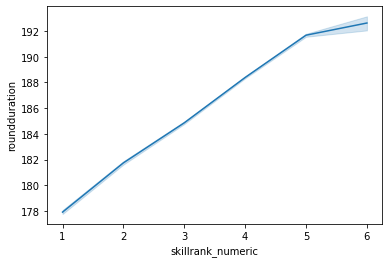

In [23]:
sns.lineplot(data=df_tmp, y="roundduration", x="skillrank_numeric")

In [24]:
df_test = pd.get_dummies(df["skillrank"], prefix="skillrank")
df_test.head()

,skillrank_Unranked,skillrank_Copper,skillrank_Bronze,skillrank_Silver,skillrank_Gold,skillrank_Platinum,skillrank_Diamond
0,0,0,0,0,1,0,0
1,0,0,0,0,1,0,0
2,0,0,0,0,1,0,0
3,0,0,0,0,1,0,0
4,0,0,0,0,1,0,0


In [25]:
df_test["matchtime"] = df["roundduration"]
df_test.head()

,skillrank_Unranked,skillrank_Copper,skillrank_Bronze,skillrank_Silver,skillrank_Gold,skillrank_Platinum,skillrank_Diamond,matchtime
0,0,0,0,0,1,0,0,185
1,0,0,0,0,1,0,0,181
2,0,0,0,0,1,0,0,225
3,0,0,0,0,1,0,0,221
4,0,0,0,0,1,0,0,221


In [26]:
del df_test, df_tmp

In [27]:
df_tmp = df.loc[~df["operator"].str.contains("RESERVE")]
df_tmp.groupby("role")["operator"].nunique()

role
Attacker    15
Defender    15
Name: operator, dtype: int64

In [28]:
list(df_tmp.groupby("role")["operator"].unique()[0])

['G.E.O.-JACKAL',
 'BOPE-CAPITAO',
 'GSG9-IQ',
 'SWAT-ASH',
 'SAS-THATCHER',
 'SAS-SLEDGE',
 'SAT-HIBANA',
 'JTF2-BUCK',
 'GIGN-TWITCH',
 'SWAT-THERMITE',
 'NAVYSEAL-BLACKBEARD',
 'SPETSNAZ-FUZE',
 'SPETSNAZ-GLAZ',
 'GIGN-MONTAGNE',
 'GSG9-BLITZ']

In [29]:
list(df_tmp.groupby("role")["operator"].unique()[1])

['BOPE-CAVEIRA',
 'NAVYSEAL-VALKYRIE',
 'GSG9-JAGER',
 'SAS-SMOKE',
 'GIGN-ROOK',
 'SWAT-CASTLE',
 'GSG9-BANDIT',
 'SWAT-PULSE',
 'JTF2-FROST',
 'G.E.O.-MIRA',
 'GIGN-DOC',
 'SAT-ECHO',
 'SAS-MUTE',
 'SPETSNAZ-KAPKAN',
 'SPETSNAZ-TACHANKA']

- über welchen zeitraum sind die daten verteilt
- an welchen tagen wird viel gespielt
- an welchen tagen spielt welcher skillrank

In [30]:
df

,dateid,platform,gamemode,mapname,matchid,roundnumber,objectivelocation,winrole,endroundreason,roundduration,...,secondarysight,secondarygrip,secondaryunderbarrel,secondarybarrel,secondarygadget,date,platform_numeric,skillrank_numeric,mapname_numeric,role_code
0,20170223,PS4,SECURE_AREA,HOUSE,977823561,5,KID'S_BEDROOM,Attacker,DefendersEliminated,185,...,None,None,Laser,None,IMPACT_GRENADE,2017-02-23,1,4,9,1
1,20170223,PS4,SECURE_AREA,HOUSE,977823561,1,MASTER_BEDROOM,Attacker,DefendersEliminated,181,...,None,None,None,None,BREACH_CHARGE,2017-02-23,1,4,9,0
2,20170223,PS4,SECURE_AREA,HOUSE,977823561,3,MASTER_BEDROOM,Defender,AttackersEliminated,225,...,None,None,Laser,None,IMPACT_GRENADE,2017-02-23,1,4,9,1
3,20170223,PS4,SECURE_AREA,HOUSE,977823561,2,GARAGE,Defender,AttackersEliminated,221,...,None,None,None,None,BREACH_CHARGE,2017-02-23,1,4,9,0
4,20170223,PS4,SECURE_AREA,HOUSE,977823561,2,GARAGE,Defender,AttackersEliminated,221,...,None,None,None,MuzzleBrake,CLAYMORE,2017-02-23,1,4,9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3999995,20170323,PS4,SECURE_AREA,PLANE,1743318881,5,LUGGAGE_HOLD,Defender,AttackersEliminated,224,...,None,None,None,None,CLAYMORE,2017-03-23,1,4,13,0
3999996,20170323,PS4,SECURE_AREA,PLANE,1743318881,5,LUGGAGE_HOLD,Defender,AttackersEliminated,224,...,None,None,Laser,MuzzleBrake,BREACH_CHARGE,2017-03-23,1,4,13,0
3999997,20170323,PS4,SECURE_AREA,PLANE,1743318881,8,LUGGAGE_HOLD,Attacker,DefendersEliminated,195,...,None,None,None,None,CLAYMORE,2017-03-23,1,4,13,0
3999998,20170323,PS4,SECURE_AREA,PLANE,1743318881,7,LUGGAGE_HOLD,Defender,ObjectiveProtected,232,...,None,None,None,None,NITRO_CELL,2017-03-23,1,5,13,1


In [31]:
df_tmp = df.loc[(df["matchid"] == 979330301) & (df["roundnumber"] == 1)][["role", "operator", "skillrank", "haswon", "mapname"]].sort_values(by="role")
df_tmp["operator_id"] = df_tmp["operator"].cat.codes
df_tmp["skillrank_id"] = df_tmp["skillrank"].cat.codes
df_tmp["map_id"] = df_tmp["mapname"].cat.codes
df_tmp

,role,operator,skillrank,haswon,mapname,operator_id,skillrank_id,map_id
265,Attacker,SWAT-ASH,Gold,0,BANK,30,4,0
270,Attacker,G.E.O.-JACKAL,Gold,0,BANK,2,4,0
272,Attacker,SPETSNAZ-GLAZ,Gold,0,BANK,26,4,0
291,Attacker,GIGN-TWITCH,Gold,0,BANK,8,4,0
292,Attacker,SAT-HIBANA,Platinum,0,BANK,24,5,0
268,Defender,GIGN-DOC,Gold,1,BANK,4,4,0
278,Defender,NAVYSEAL-VALKYRIE,Silver,1,BANK,17,3,0
279,Defender,GIGN-ROOK,Gold,1,BANK,7,4,0
281,Defender,GSG9-JAGER,Gold,1,BANK,12,4,0
286,Defender,GSG9-BANDIT,Gold,1,BANK,9,4,0


## Multibinomial Naive Bayes

In [33]:
df.head()

,dateid,platform,gamemode,mapname,matchid,roundnumber,objectivelocation,winrole,endroundreason,roundduration,...,secondarysight,secondarygrip,secondaryunderbarrel,secondarybarrel,secondarygadget,date,platform_numeric,skillrank_numeric,mapname_numeric,role_code
0,20170223,PS4,SECURE_AREA,HOUSE,977823561,5,KID'S_BEDROOM,Attacker,DefendersEliminated,185,...,None,None,Laser,None,IMPACT_GRENADE,2017-02-23,1,4,9,1
1,20170223,PS4,SECURE_AREA,HOUSE,977823561,1,MASTER_BEDROOM,Attacker,DefendersEliminated,181,...,None,None,None,None,BREACH_CHARGE,2017-02-23,1,4,9,0
2,20170223,PS4,SECURE_AREA,HOUSE,977823561,3,MASTER_BEDROOM,Defender,AttackersEliminated,225,...,None,None,Laser,None,IMPACT_GRENADE,2017-02-23,1,4,9,1
3,20170223,PS4,SECURE_AREA,HOUSE,977823561,2,GARAGE,Defender,AttackersEliminated,221,...,None,None,None,None,BREACH_CHARGE,2017-02-23,1,4,9,0
4,20170223,PS4,SECURE_AREA,HOUSE,977823561,2,GARAGE,Defender,AttackersEliminated,221,...,None,None,None,MuzzleBrake,CLAYMORE,2017-02-23,1,4,9,0


In [34]:
df.shape

(4000000, 36)

In [37]:
df["gamemode"].value_counts()

SECURE_AREA    2618694
BOMB            945327
HOSTAGE         435979
Name: gamemode, dtype: int64

In [39]:
df["platform"].value_counts()

PS4     2078280
XONE    1354408
PC       567312
Name: platform, dtype: int64

In [59]:
def load_data():
    file_path_list = []
    for i in range(0, 10):
        file_path_list.append(f"./data/datadump_s5-00{i}.csv")

    for i in range(10, 22):
        file_path_list.append(f"./data/datadump_s5-0{i}.csv")

    df_list = []
    for file_path in tqdm(file_path_list):
        df = pd.read_csv(
            file_path,
            usecols=[
                "dateid",
                "platform",
                "gamemode",
                "mapname",
                "matchid",
                "roundnumber",
                "objectivelocation",
                "winrole",
                "roundduration",
                "skillrank",
                "clearancelevel",
                "role",
                "team",
                "haswon",
                "operator",
                "nbkills",
                "isdead"
            ],
            dtype={
                "platform": "category",
                "gamemode": "category",
                "mapname": "category",
                "objectivelocation": "category",
                "winrole": "category",
                "endroundreason": "category",
                "skillrank": "category",
                "role": "category",
                "operator": "category",
            }
        )
        df_list.append(df.loc[(df["platform"] == "PC") & (df["gamemode"] == "BOMB")])

    return pd.concat(df_list, ignore_index=True)

In [60]:
df = load_data()
df.shape

100%|██████████| 22/22 [04:18<00:00, 11.73s/it]


(3889573, 17)

In [63]:
sys.getsizeof(df) / (1024 ** 2)

300.48085021972656

In [62]:
df.head()

,dateid,platform,gamemode,mapname,matchid,roundnumber,objectivelocation,winrole,roundduration,clearancelevel,skillrank,role,team,haswon,operator,nbkills,isdead
0,20170212,PC,BOMB,BARTLETT_U.,1529883301,6,ROWING_MUSEUM-TROPHY_ROOM,Attacker,246,147,Platinum,Attacker,1,1,JTF2-BUCK,1,1
1,20170212,PC,BOMB,BARTLETT_U.,1529883301,2,READING_ROOM-LIBRARY,Defender,231,40,Unranked,Defender,0,1,GIGN-ROOK,0,1
2,20170212,PC,BOMB,BARTLETT_U.,1529883301,4,KITCHEN-PIANO_ROOM,Attacker,233,60,Gold,Defender,0,0,G.E.O.-MIRA,0,1
3,20170212,PC,BOMB,BARTLETT_U.,1529883301,6,ROWING_MUSEUM-TROPHY_ROOM,Attacker,246,40,Unranked,Defender,0,0,GIGN-ROOK,0,1
4,20170212,PC,BOMB,BARTLETT_U.,1529883301,7,CLASSROOM-LIBRARY,Attacker,168,56,Unranked,Defender,0,0,SWAT-CASTLE,0,1


In [83]:
df_test = df.loc[(df["matchid"] == 1529883301) & (df["roundnumber"] == 6)][["operator", "winrole", "mapname"]]
df_test

,operator,winrole,mapname
1042080,JTF2-BUCK,Attacker,BARTLETT_U.
1042081,GIGN-ROOK,Attacker,BARTLETT_U.
1042082,SWAT-CASTLE,Attacker,BARTLETT_U.
1042083,SAT-HIBANA,Attacker,BARTLETT_U.
1042084,G.E.O.-JACKAL,Attacker,BARTLETT_U.
1042085,G.E.O.-MIRA,Attacker,BARTLETT_U.
1042086,GIGN-TWITCH,Attacker,BARTLETT_U.
1042087,BOPE-CAVEIRA,Attacker,BARTLETT_U.
1042088,GSG9-BANDIT,Attacker,BARTLETT_U.
1042089,SAS-SLEDGE,Attacker,BARTLETT_U.


In [94]:
winrole = df_test.iloc[0]["winrole"]
mapname = df_test.iloc[0]["mapname"]
operator = df_test["operator"].to_list()
operator.extend([winrole, mapname])
operator

['JTF2-BUCK',
 'GIGN-ROOK',
 'SWAT-CASTLE',
 'SAT-HIBANA',
 'G.E.O.-JACKAL',
 'G.E.O.-MIRA',
 'GIGN-TWITCH',
 'BOPE-CAVEIRA',
 'GSG9-BANDIT',
 'SAS-SLEDGE',
 'Attacker',
 'BARTLETT_U.']

In [102]:
df.groupby(["matchid", "roundnumber", "role"])["operator"].to_list()

AttributeError: 'SeriesGroupBy' object has no attribute 'to_list'

In [69]:
df_player_count = df.groupby(["matchid", "roundnumber"])["operator"].count().reset_index(name="player_count")
df_player_count.shape

(402810, 3)

In [70]:
df_player_count["player_count"].value_counts()

10    292960
9      87349
8      17451
7       3524
6        939
5        242
4         74
2         66
1         46
20        38
3         34
19        31
12        13
18        13
11        12
13        10
17         7
16         1
Name: player_count, dtype: int64

In [74]:
df_player_count = df_player_count.loc[df_player_count["player_count"] == 10]

In [76]:
df = df.merge(right=df_player_count, how="right", on=["matchid", "roundnumber"])

In [79]:
for _, group in df.groupby(["matchid", "roundnumber"]):
    group["operator"]

10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
1

KeyboardInterrupt: 

In [38]:
df_tmp = df.loc[(df["platform"] == "PC") & (df["gamemode"] == "BOMB")]
df_tmp.shape

(191985, 36)